In [1]:
# Importing a bunch of tools/libs
import torch
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

torch.__version__, np.__version__, pd.__version__

('2.6.0', '2.2.2', '2.2.3')

# Data

Using the tiny-imagenet dataset, found here: http://cs231n.stanford.edu/tiny-imagenet-200.zip

Contents:
- 200 classes
- 500 samples per **train** class
- 50 samples per **validation** class
- Total file size: 239.7 MB

Not using the full ImageNet dataset for compute-time and dataset-size.

## Load data

In [2]:
### Setup data-dir
current_dir = Path(os.getcwd())
data_dir = current_dir.parent.parent / "datasets" / "ImageNet" / "data"  # I save all the datasets in this dir.
train_dir = data_dir / "train"
val_dir = data_dir / "val"

data_dir_content = os.listdir(data_dir)
print(f"[INFO] Data-dir content: {data_dir_content}")

[INFO] Data-dir content: ['.DS_Store', 'test', 'wnids.txt', 'train', 'words.txt', 'val']


In [3]:
### Training data
# Load class labels
with open(data_dir/"wnids.txt", "r") as f:
    class_labels = {line.strip(): idx for idx, line in enumerate(f)}
print(f"[INFO] Loaded class_labels: {len(class_labels)}")

# Load data
train_data = []
for class_id, label in class_labels.items():
    class_path = train_dir / class_id / "images"
    for img in os.listdir(class_path):
        train_data.append((class_path/img, label, class_id))
print(f"[INFO] Loaded train_data: {len(train_data)}")

[INFO] Loaded class_labels: 200
[INFO] Loaded train_data: 100000


In [4]:
### val data
# Load annotations
def filter_annotation(annotations):
    # Used p much for the val data only
    return {
        line.split("\t")[0]: line.split("\t")[1]
        for line in annotations
    }
with open(val_dir / "val_annotations.txt", "r") as f:
    val_mapping = filter_annotation(f)
print(f"[INFO] Loaded val annotations: {len(val_mapping)}")

# Load data
val_data = []
for img in os.listdir(val_dir/"images"):
    val_data.append((val_dir/"images"/img, class_labels[val_mapping[img]], val_mapping[img]))
print(f"[INFO] Loaded val data: {len(val_data)}")

[INFO] Loaded val annotations: 10000
[INFO] Loaded val data: 10000


In [5]:
# Store into a df
train_df = pd.DataFrame(train_data, columns=["image_path", "label", "wnid"])
val_df = pd.DataFrame(val_data, columns=["image_path", "label", "wnid"])
#train_df.head()
#val_df.head()


## Understand the data

Most of the important filtering has been done.\
We just need to know some basic metrics of the dataset, things like: class-distribution, etc

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image_path  100000 non-null  object
 1   label       100000 non-null  int64 
 2   wnid        100000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


In [7]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  10000 non-null  object
 1   label       10000 non-null  int64 
 2   wnid        10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [8]:
# Check for repetition and "extra classes"
train_df.nunique()

image_path    100000
label            200
wnid             200
dtype: int64

In [9]:
# Check class-distribution
train_df["label"].value_counts().sort_index().describe()

count    200.0
mean     500.0
std        0.0
min      500.0
25%      500.0
50%      500.0
75%      500.0
max      500.0
Name: count, dtype: float64

No issues here

In [10]:
# Define the class_names (mapping: idx -> class)
class_names = list(class_labels.keys())
class_names[:5]

['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582']

`class_names` is the mapping from 'label-encoding' -> 'class-name'/'label'

Image label: 182
Image dims: (64, 64)
Image id: 91393


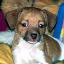

In [11]:
import PIL
import random

# Get random image
random_image_idx = random.choice(range(len(train_df["image_path"])))
random_image_path = train_df["image_path"].iloc[random_image_idx]
image = PIL.Image.open(random_image_path)
label = train_df["label"].iloc[random_image_idx]

# Get some info about the image
print(f"Image label: {label}")
print(f"Image dims: ({image.height}, {image.width})")
print(f"Image id: {random_image_idx}")

image

In [12]:
# View the image as an array
image_array = np.asarray(image)
print(f"Image shape: {image_array.shape}")
print(image_array)

Image shape: (64, 64, 3)
[[[ 12  12  12]
  [ 11  10   6]
  [ 49  47  34]
  ...
  [122 109  67]
  [117 101  85]
  [ 95  79  80]]

 [[  2   2   0]
  [ 18  17  12]
  [ 58  56  43]
  ...
  [119 113  79]
  [118 111 103]
  [104  98 108]]

 [[  0   1   0]
  [ 35  37  26]
  [ 76  75  57]
  ...
  [102 109  91]
  [ 90 101 107]
  [ 80  92 116]]

 ...

 [[255 237 133]
  [255 221 121]
  [247 212 120]
  ...
  [ 88 104  78]
  [ 81  99  73]
  [ 62  80  56]]

 [[224 190  83]
  [233 199  99]
  [247 214 119]
  ...
  [110 114  77]
  [ 91  95  58]
  [ 66  72  34]]

 [[169 136  29]
  [194 161  58]
  [211 178  83]
  ...
  [148 145 100]
  [126 123  78]
  [100  97  52]]]


## Preprocessing

Things like dataloaders, transforms (for augmentation), etc.\
Will try to make this as close to the paper as possible (I may add things that I prefer too).

### Create torch-dataset(s)

Creating the train and validation dataset(s).
They will return the image (as tensor) and a class-label (0-199)

In [13]:
from torch.utils.data import DataLoader  # to create torch DataLoaders
from torchvision import transforms, datasets  # to create custom datasets and transforms

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.1),  # optional | could aid generalization
    # i think thats enough for now, will change stuff here based on model outcomes
])

data_transform

Compose(
    ToTensor()
    RandomHorizontalFlip(p=0.3)
    RandomVerticalFlip(p=0.1)
)

Found [this](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) helpful for creating the following (custom) torch-dataset.

In [22]:
# val dataset
from torch.utils.data import Dataset
from skimage import io

class ImageNetDataset(Dataset):
    """Creates a custom dataset for the Validation-split."""
    def __init__(self,
                 data: list[tuple],
                 transform=None):
        self.image_paths = [tup[0] for tup in data]
        self.image_labels = [tup[1] for tup in data]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read/load image from path at idx
        img_path = self.image_paths[idx]
        
        # ImageNet has grey-scale images too (found that the hardway)
        image = PIL.Image.open(img_path).convert('RGB')  # fix: https://discuss.pytorch.org/t/convert-grayscale-images-to-rgb/113422/4
        
        # Apply transform
        if self.transform:
            image = self.transform(image)
        
        return image, self.image_labels[idx]


In [23]:
# Create custom datasets
train_dataset = ImageNetDataset(
    data=train_data,
    transform=data_transform,
)
print(f"Train-dataset length: {len(train_dataset)}")

val_dataset = ImageNetDataset(
    data=val_data,
    transform=data_transform,
)
print(f"Val-dataset length: {len(val_dataset)}")

Train-dataset length: 100000
Val-dataset length: 10000


In [24]:
# Test train-dataset
image, label = random.choice(train_dataset)
print(f"Random image label: {label}")
image

Random image label: 125


tensor([[[0.4039, 0.4314, 0.5843,  ..., 0.5373, 0.0784, 0.0980],
         [0.5294, 0.5961, 0.4706,  ..., 0.6510, 0.1020, 0.2275],
         [0.8627, 0.6118, 0.5059,  ..., 0.5216, 0.1098, 0.0980],
         ...,
         [0.7020, 0.5529, 0.5647,  ..., 0.4196, 0.2039, 0.2235],
         [0.6784, 0.6196, 0.6353,  ..., 0.3490, 0.2510, 0.2196],
         [0.7608, 0.6314, 0.8039,  ..., 0.3569, 0.3255, 0.2118]],

        [[0.3020, 0.3294, 0.4824,  ..., 0.4745, 0.0118, 0.0275],
         [0.4275, 0.4941, 0.3686,  ..., 0.5882, 0.0353, 0.1569],
         [0.7647, 0.5137, 0.4078,  ..., 0.4588, 0.0431, 0.0275],
         ...,
         [0.6353, 0.4863, 0.4980,  ..., 0.3529, 0.1294, 0.1412],
         [0.6118, 0.5529, 0.5686,  ..., 0.2824, 0.1765, 0.1373],
         [0.6941, 0.5647, 0.7373,  ..., 0.2902, 0.2510, 0.1294]],

        [[0.2039, 0.2392, 0.3922,  ..., 0.4235, 0.0000, 0.0118],
         [0.3373, 0.4039, 0.2784,  ..., 0.5373, 0.0078, 0.1412],
         [0.6784, 0.4275, 0.3216,  ..., 0.4078, 0.0118, 0.

In [25]:
# Test val-dataset
image, label = random.choice(val_dataset)
print(f"Random image label: {label}")
image

Random image label: 5


tensor([[[0.6039, 0.6392, 0.6824,  ..., 0.1451, 0.1569, 0.1765],
         [0.6941, 0.6471, 0.6196,  ..., 0.1373, 0.1451, 0.1647],
         [0.6118, 0.6196, 0.6549,  ..., 0.1412, 0.1451, 0.1529],
         ...,
         [0.2392, 0.2706, 0.5647,  ..., 0.4235, 0.3020, 0.3098],
         [0.2824, 0.2627, 0.2667,  ..., 0.4157, 0.2784, 0.3451],
         [0.5098, 0.2863, 0.1922,  ..., 0.3647, 0.5020, 0.7490]],

        [[0.6392, 0.6745, 0.7098,  ..., 0.1961, 0.2078, 0.2275],
         [0.7294, 0.6824, 0.6431,  ..., 0.1882, 0.1961, 0.2078],
         [0.6471, 0.6549, 0.6784,  ..., 0.1882, 0.1882, 0.1961],
         ...,
         [0.3098, 0.3412, 0.6353,  ..., 0.5216, 0.4039, 0.4157],
         [0.3529, 0.3333, 0.3294,  ..., 0.5216, 0.3961, 0.4627],
         [0.5804, 0.3569, 0.2549,  ..., 0.4784, 0.6196, 0.8667]],

        [[0.2745, 0.3098, 0.3451,  ..., 0.1176, 0.1373, 0.1569],
         [0.3725, 0.3255, 0.2902,  ..., 0.1176, 0.1294, 0.1451],
         [0.2980, 0.3059, 0.3412,  ..., 0.1333, 0.1333, 0.

In [26]:
# Check the image dims
image, _ = random.choice(train_dataset)
image.ndim, image.shape

(3, torch.Size([3, 64, 64]))

Suggests that the images are in shape: (C,H,W) | (Channels, Height, Width)

In [27]:
# Check the image dims for the val-dataset
image, _ = random.choice(val_dataset)
image.ndim, image.shape

(3, torch.Size([3, 64, 64]))

The shapes are matching, datasets are ready.

### Create `Dataloader`s

In [28]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # this is best for MPS
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,  # same as train
)

train_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16c3389e0>,
 <torch.utils.data.dataloader.DataLoader at 0x16c4df2f0>)

In [29]:
# Test the dataloaders
# Train
image, label = next(iter(train_dataloader))
print(f"Train dataloader:\n{image.shape, label}")

# Val
image, label = next(iter(val_dataloader))
print(f"Val dataloader:\n{image.shape, label}")

Train dataloader:
(torch.Size([32, 3, 64, 64]), tensor([ 43, 172,  49, 162, 170,  94,  51,  92,  28,  70, 156, 146,   7, 142,
         63,  27,  62,  69, 188,   1, 126, 197,  99,  13,  89, 137, 171,  10,
         17,  46, 161,  92]))
Val dataloader:
(torch.Size([32, 3, 64, 64]), tensor([106,  70, 111, 192, 158, 136,  79, 167,  17,  85, 127, 199,  13, 130,
         43, 198,  22, 182, 132, 148,   8, 128,  51,  44, 131, 116,  98,  47,
         73,  72, 100,  50]))


Suggests that the shapes follow: (B,C,H,W)\
Kinda expected, and thats a good thing.

In [49]:
# view some random images from the dataloader (making sure that its working as expected)
def disp_images(dataset, classes, n):
    """Randomly chooses and plots images from dataset"""
    n = 10 if n > 10 else n
    
    random_samples = random.sample(range(len(dataset)), k=n)
    
    # Plot
    plt.figure(figsize=(20, 10))
    for i, sample in enumerate(random_samples):
        image, label = dataset[sample]  # image: (C,H,W)
        image = image.permute(1, 2, 0)  # image: (H,W,C) | for plotting
        
        plt.subplot(1, n, i+1)
        plt.imshow(image)
        plt.title(f"Class: {classes[label]}\nShape: {tuple(image.shape)}")
        plt.axis(False)
    
    plt.show();

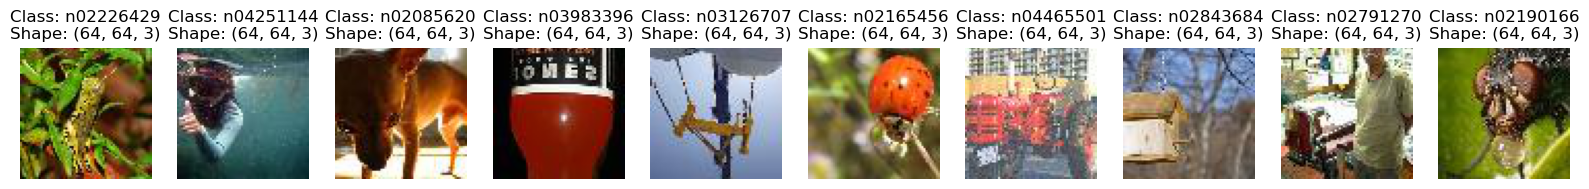

In [50]:
disp_images(train_dataset, class_names, n=10)

# Model

## Classes

Define the custom ResNet class that implements the "ResNet" architecture.

ConvBlock: conv2d -> batch-norm -> relu\
Block (all the conv-layers with consistent # of channels): ConvBlock -> ConvBlock ... (n_conv times)\
ResNet: Block(1) -> Block(2) -> Block(3) ... (n_block times)

In [398]:
import torch.nn as nn

# Define a single "conv" block
class ConvBlock(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 stride = 1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=3,
                              padding=1,
                              stride=stride,
                              bias=False)  # we are using bn
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.activation = nn.ReLU(inplace=True)
    
    def forward(self, x):
        return self.activation(self.bn(self.conv(x)))

class Block(nn.Module):
    def __init__(self,
                 in_channels: int,
                 const_channels: int,
                 n_conv: int,
                 downsample: bool = False,
                 info: list or None = None,
                 debug: bool = False):
        super().__init__()
        
        stride = 2 if downsample else 1
        self.Ws = None
        if in_channels != const_channels or downsample:
            self.Ws = nn.Sequential(
                nn.Conv2d(in_channels, const_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(const_channels),
            )
        self.cast_block = ConvBlock(in_channels, const_channels, stride=stride)
        self.conv_layers = nn.ModuleList([
            ConvBlock(const_channels, const_channels) for _ in range(n_conv-1)
        ])

        self._misc = [in_channels, const_channels, n_conv, downsample, info]
        self._debug = debug
        

    def forward(self, x):
        identity = x
        
        if self._debug:
            print("---"*3)
            print(self._misc)
            print(f"identity_b4:\t\t {identity.shape}")
        if self.Ws is not None:
            identity = self.Ws(identity)
            if self._debug:
                print(f"identity_af:\t\t {identity.shape}")

        out = self.cast_block(x)
        if self._debug:
            print(f"out_cast (conv):\t\t {out.shape}")
        for conv_layer in self.conv_layers:
            out = conv_layer(out) + identity
            if self._debug:
                print(f"out_conv_layers:\t {out.shape}")
        return out

Block(in_channels=3, const_channels=4, downsample=True, n_conv=4)(next(iter(train_dataloader))[0]).shape

torch.Size([32, 4, 32, 32])

In [405]:
class ResNet(nn.Module):
    def __init__(self,
                 in_channels: int,
                 start_channels: int,
                 n_blocks: int,
                 n_conv: list[int],
                 verbose: bool = False):
        super().__init__()
        # 1st block
        self.start_block = Block(in_channels,
                                 start_channels,
                                 n_conv[0],
                                 downsample=False,
                                 info=["start-block", f"mapping from: ({in_channels}) to ({start_channels})"],
                                 debug=verbose)

        # Rest of the blocks
        self.blocks = nn.ModuleList()
        for i in range(0, n_blocks-1):
            _n_convs = n_conv[i] if isinstance(n_conv, list) and len(n_conv) == n_blocks - 1 else n_conv[0]
            self.blocks.append(Block(start_channels * 2**i,
                                     start_channels * 2**(i+1),
                                     _n_convs,
                                     downsample=True,
                                     info=[f"mapping from: ({start_channels*2**i}) to ({start_channels*2**(i+1)})"],
                                     debug=verbose))
        
        # Classifier
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # For converting: (B,C,H,W) -> (B,C,1,1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(start_channels * 2**(n_blocks-1), len(class_names), bias = True),
        )
        if verbose:
            print(f"[INFO] Linear layer mapping from: ({start_channels * 2**(n_blocks-1)}) to: ({len(class_names)})")
    
    def forward(self, x):
        x = self.start_block(x)
        for block in self.blocks:
            x = block(x)
        x = self.global_avg_pool(x)
        x = self.classifier(x)
        return x

ResNet(in_channels=3,
       start_channels=32,
       n_blocks=4,
       n_conv=[4],
       verbose=True)(next(iter(train_dataloader))[0]).shape

[INFO] Linear layer mapping from: (256) to: (200)
---------
[3, 32, 4, False, ['start-block', 'mapping from: (3) to (32)']]
identity_b4:		 torch.Size([32, 3, 64, 64])
identity_af:		 torch.Size([32, 32, 64, 64])
out_cast (conv):		 torch.Size([32, 32, 64, 64])
out_conv_layers:	 torch.Size([32, 32, 64, 64])
out_conv_layers:	 torch.Size([32, 32, 64, 64])
out_conv_layers:	 torch.Size([32, 32, 64, 64])
---------
[32, 64, 4, True, ['mapping from: (32) to (64)']]
identity_b4:		 torch.Size([32, 32, 64, 64])
identity_af:		 torch.Size([32, 64, 32, 32])
out_cast (conv):		 torch.Size([32, 64, 32, 32])
out_conv_layers:	 torch.Size([32, 64, 32, 32])
out_conv_layers:	 torch.Size([32, 64, 32, 32])
out_conv_layers:	 torch.Size([32, 64, 32, 32])
---------
[64, 128, 4, True, ['mapping from: (64) to (128)']]
identity_b4:		 torch.Size([32, 64, 32, 32])
identity_af:		 torch.Size([32, 128, 16, 16])
out_cast (conv):		 torch.Size([32, 128, 16, 16])
out_conv_layers:	 torch.Size([32, 128, 16, 16])
out_conv_layers

torch.Size([32, 200])

In [408]:
from torchinfo import summary
model_0 = ResNet(3, 8, 4, [8])
summary(model_0, input_data=next(iter(train_dataloader))[0])

Layer (type:depth-idx)                        Output Shape              Param #
ResNet                                        [32, 200]                 --
├─Block: 1-1                                  [32, 8, 64, 64]           --
│    └─Sequential: 2-1                        [32, 8, 64, 64]           --
│    │    └─Conv2d: 3-1                       [32, 8, 64, 64]           24
│    │    └─BatchNorm2d: 3-2                  [32, 8, 64, 64]           16
│    └─ConvBlock: 2-2                         [32, 8, 64, 64]           --
│    │    └─Conv2d: 3-3                       [32, 8, 64, 64]           216
│    │    └─BatchNorm2d: 3-4                  [32, 8, 64, 64]           16
│    │    └─ReLU: 3-5                         [32, 8, 64, 64]           --
│    └─ModuleList: 2-3                        --                        --
│    │    └─ConvBlock: 3-6                    [32, 8, 64, 64]           592
│    │    └─ConvBlock: 3-7                    [32, 8, 64, 64]           592
│    │    └─ConvB

## Training

|layer name|output size|18-layer|34-layer|
|-|-|-|-|
|conv1|64x64|3x3,64,downsample=False|3x3,64,downsample=False|
|conv2_x|32x32|[3x3,128,True] x 2|[3x3,128,True] x 3|
|conv3_x|16x16|[3x3,256,True] x 2|[3x3,256,True] x 4|
|conv4_x|8x8|[3x3,512,True] x 2|[3x3,512,True] x 6|
|conv5_x|4x4|[3x3,1024,True] x 2|[3x3,1024,True] x 3|

Downsample: essentially performs convolution with stride=2. Therefore "halve" the input signal's (H,W) dims.

*I tried to keep the specs as close as possible to the paper. They had be 'altered' for the dataset im using.

**Optimizer**: Using **SGD** (paper). Ill also train with **Adam** and **AdamW** optimizers too and compare the results.

### 18-layer ResNet

|model name|optimizer|results|
|-|-|-|
|model_18_sgd|SGD|-|
|model_18_adam|Adam|-|
|model_18_adamw|AdamW|-|

**Naming convention**: "model" + (num layers/config from above) + (optimizer)

In [409]:
# Create model
model_18_sgd = ResNet(
    in_channels=3,
    start_channels=64,
    n_blocks=5,
    n_conv=[2],
)

# Get model summary
summary(model_18_sgd, input_data=next(iter(train_dataloader))[0])

Layer (type:depth-idx)                        Output Shape              Param #
ResNet                                        [32, 200]                 --
├─Block: 1-1                                  [32, 64, 64, 64]          --
│    └─Sequential: 2-1                        [32, 64, 64, 64]          --
│    │    └─Conv2d: 3-1                       [32, 64, 64, 64]          192
│    │    └─BatchNorm2d: 3-2                  [32, 64, 64, 64]          128
│    └─ConvBlock: 2-2                         [32, 64, 64, 64]          --
│    │    └─Conv2d: 3-3                       [32, 64, 64, 64]          1,728
│    │    └─BatchNorm2d: 3-4                  [32, 64, 64, 64]          128
│    │    └─ReLU: 3-5                         [32, 64, 64, 64]          --
│    └─ModuleList: 2-3                        --                        --
│    │    └─ConvBlock: 3-6                    [32, 64, 64, 64]          36,992
├─ModuleList: 1-2                             --                        --
│    └─Blo

In [427]:
# Train loop
from torch import optim
from tqdm.auto import tqdm

def accuracy_fn(y_pred: torch.Tensor, y_true: torch.Tensor):
    """
    Args:
        y_pred (torch.Tensor): pred labels
        y_true (torch.Tensor): true labels

    Returns:
        accuracy (float): ranging from 0-100
    """
    return (torch.eq(y_true, y_pred).sum().item() / len(y_pred)) * 100

def train(model: nn.Module,
          device: torch.device,
          train_dataloader: DataLoader,
          val_dataloader: DataLoader,
          loss_fn: nn.Module,
          optimizer: optim.Optimizer,
          epochs: int,
          print_freq: int = 1):
    # Send model to device
    model.to(device)
    # Store model performance during train
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }
    
    # Start training for "epochs"
    for epoch in tqdm(range(1, epochs+1),  # easier to print
                      desc="training model",
                      leave=True):
        # Common for both train and test/val steps
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        
        # Train step
        model.train()
        for X, y in tqdm(train_dataloader, total=len(train_dataloader),
                         desc="train_step",
                         leave=False):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)  # running loss

            # Update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # For mean loss/acc over train-data
            train_loss += loss.item()
            train_acc += accuracy_fn(y_pred.argmax(dim=1), y)  # running acc | skiping the softmax, not needed here
        
        # Test/val step
        model.eval()
        with torch.inference_mode():
            for X, y in tqdm(val_dataloader, total=len(val_dataloader),
                             desc="test_step",
                             leave=False):
                # Get model preds
                X, y = X.to(device), y.to(device)
                y_pred = model(X)

                # Calc and update test-loss and test-acc with running loss and acc
                test_loss += loss_fn(y_pred, y).item()
                test_acc += accuracy_fn(y_pred.argmax(dim=1), y)
        
        # Save to results
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        test_loss /= len(val_dataloader)
        test_acc /= len(val_dataloader)
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(train_loss)
        results["test_acc"].append(train_acc)
        if epoch % print_freq == 0:
            print(f"Epoch: {epoch}/{epochs} | train_loss: {train_loss:.4f} | test_loss: {test_loss:.4f} | train_acc: {train_acc:.2f} | test_acc: {test_acc:.2f}")
    return results

In [428]:
# Define the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [430]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model_18_sgd.parameters(),
                      momentum=0.9,
                      lr=1e-3)
model_18_sgd.compile(backend="aot_eager")

results_18_sgd = train(
    model=model_18_sgd,
    device=device,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=1,
)

training model:   0%|          | 0/1 [00:00<?, ?it/s]

train_step:   0%|          | 0/3125 [00:00<?, ?it/s]

KeyboardInterrupt: 